In [1]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

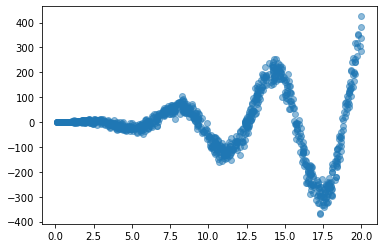

In [2]:
x = np.random.uniform(0, 20, 1000)
y = x**2 * np.sin(x) + 2*x*np.random.randn(1000)
plt.scatter(x, y, alpha=0.5)

X = x.reshape(1000,1)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

## Decision trees, which are know for being bad at being smooth

In [4]:
model = XGBRegressor(random_state=2, max_depth=3)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=2, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

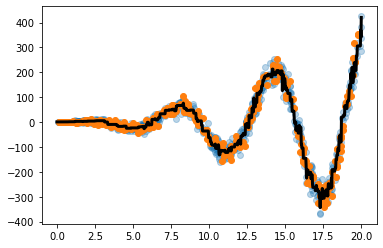

In [5]:
x_ = np.linspace(0,20, 1000).reshape(1000,1)
y_pred = model.predict(x_)

plt.scatter(X_train, y_train, alpha=0.3)
plt.scatter(X_test,y_test, alpha=1)


plt.plot(x_, y_pred, lw=3, color='black')

### Trying derivatives

In [6]:
from sklearn.metrics import mean_squared_error

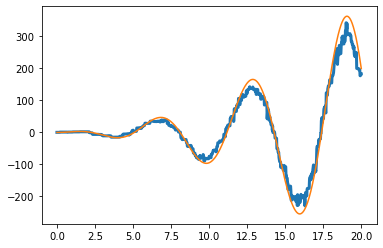

In [7]:
# large step for derivative
h = 1

plt.plot(x_, (model.predict(x_+h) - model.predict(x_-h))/(2*h), lw=3)
plt.plot(x_, 2*x_*np.sin(x_) + x_**2*np.cos(x_))
plt.show()

In [8]:
print("RMSE derivative:", round(np.sqrt(mean_squared_error(
    (model.predict(x_+h) - model.predict(x_-h))/(2*h), 
    2*x_*np.sin(x_) + x_**2*np.cos(x_))),2)
)

RMSE derivative: 24.73


This is actually pretty good!

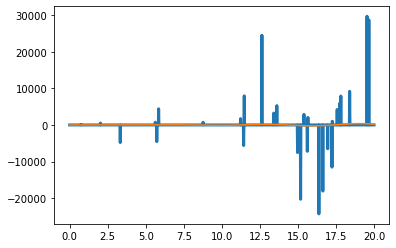

In [9]:
# small step for derivative
h = 0.001

plt.plot(x_, (model.predict(x_+h) - model.predict(x_-h))/(2*h), lw=3)
plt.plot(x_, 2*x_*np.sin(x_) + x_**2*np.cos(x_))
plt.show()

In [10]:
print("RMSE derivative:", round(np.sqrt(mean_squared_error(
    (model.predict(x_+h) - model.predict(x_-h))/(2*h), 
    2*x_*np.sin(x_) + x_**2*np.cos(x_))),2)
)

RMSE derivative: 2067.35


Clearly we get a good estimate for the derivative if $h$ is large enough, since the model is discontinuous!

## Now with a smooth neural network
Needs aa custom activation, which is differentiable and works for this case

In [11]:
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

from tensorflow import nn

In [12]:
normalize = lambda x: (x - x.mean())/x.std()

X_train_ = normalize(X_train)
y_train_ = normalize(y_train)

X_test_ = normalize(X_test)
y_test_ = normalize(y_test)

In [13]:
# inspired by 
# https://stats.stackexchange.com/questions/329776/approximating-leaky-relu-with-a-differentiable-function
def soft_leaky_relu(x, a=0.3):
     return a*x + (1-a)*nn.softplus(x)

model = Sequential()
model.add(Dense(5, input_shape=(1,), activation=soft_leaky_relu))
model.add(Dense(5, activation=soft_leaky_relu))
model.add(Dense(5, activation=soft_leaky_relu))
model.add(Dense(5, activation=soft_leaky_relu))
model.add(Dense(1, activation=soft_leaky_relu))


model.compile(
    optimizer=RMSprop(learning_rate=0.005, rho=0.8), # esse que era o problema 0.005; 
    loss="mean_squared_error")                       # diminui rho pra cair mais rapido

model.fit(X_train_, y_train_, epochs=200, batch_size=3, 
          validation_data=(X_test_, y_test_),
#         callbacks=[EarlyStopping(monitor='loss', patience=10)]
         )

Epoch 1/200
234/234 [==============================] - 1s 2ms/step - loss: 1.0008 - val_loss: 1.0003
Epoch 2/200
234/234 [==============================] - 0s 1ms/step - loss: 1.0007 - val_loss: 0.9783
Epoch 3/200
234/234 [==============================] - 0s 1ms/step - loss: 0.9985 - val_loss: 0.9759
Epoch 4/200
234/234 [==============================] - 0s 2ms/step - loss: 0.9959 - val_loss: 0.9762
Epoch 5/200
234/234 [==============================] - 0s 2ms/step - loss: 0.9973 - val_loss: 0.9696
Epoch 6/200
234/234 [==============================] - 0s 2ms/step - loss: 0.9990 - val_loss: 0.9710
Epoch 7/200
234/234 [==============================] - 0s 2ms/step - loss: 0.9979 - val_loss: 0.9783
Epoch 8/200
234/234 [==============================] - 0s 2ms/step - loss: 0.9918 - val_loss: 0.9736
Epoch 9/200
234/234 [==============================] - 0s 1ms/step - loss: 0.9963 - val_loss: 0.9684
Epoch 10/200
234/234 [==============================] - 0s 1ms/step - loss: 0.9983 - val_lo

234/234 [==============================] - 0s 2ms/step - loss: 0.6477 - val_loss: 0.6995
Epoch 82/200
234/234 [==============================] - 0s 1ms/step - loss: 0.6272 - val_loss: 0.5879
Epoch 83/200
234/234 [==============================] - 0s 2ms/step - loss: 0.5829 - val_loss: 0.6283
Epoch 84/200
234/234 [==============================] - 0s 2ms/step - loss: 0.6155 - val_loss: 0.5486
Epoch 85/200
234/234 [==============================] - 0s 1ms/step - loss: 0.5952 - val_loss: 0.5686
Epoch 86/200
234/234 [==============================] - 0s 1ms/step - loss: 0.5694 - val_loss: 0.5128
Epoch 87/200
234/234 [==============================] - 0s 1ms/step - loss: 0.5321 - val_loss: 0.6294
Epoch 88/200
234/234 [==============================] - 0s 1ms/step - loss: 0.5492 - val_loss: 0.4486
Epoch 89/200
234/234 [==============================] - 0s 2ms/step - loss: 0.5136 - val_loss: 0.5384
Epoch 90/200
234/234 [==============================] - 0s 1ms/step - loss: 0.4702 - val_loss: 

Epoch 161/200
234/234 [==============================] - 0s 2ms/step - loss: 0.1319 - val_loss: 0.1432
Epoch 162/200
234/234 [==============================] - 0s 2ms/step - loss: 0.1257 - val_loss: 0.1376
Epoch 163/200
234/234 [==============================] - 0s 2ms/step - loss: 0.1255 - val_loss: 0.1140
Epoch 164/200
234/234 [==============================] - 0s 2ms/step - loss: 0.1174 - val_loss: 0.0821
Epoch 165/200
234/234 [==============================] - 0s 2ms/step - loss: 0.1234 - val_loss: 0.0889
Epoch 166/200
234/234 [==============================] - 0s 2ms/step - loss: 0.1317 - val_loss: 0.0668
Epoch 167/200
234/234 [==============================] - 0s 2ms/step - loss: 0.1251 - val_loss: 0.0996
Epoch 168/200
234/234 [==============================] - 0s 2ms/step - loss: 0.1261 - val_loss: 0.1306
Epoch 169/200
234/234 [==============================] - 0s 2ms/step - loss: 0.1231 - val_loss: 0.1034
Epoch 170/200
234/234 [==============================] - 0s 2ms/step - lo

In [15]:
def dl_model(model, X_train, y_train):
    mean_x, mean_y = X_train.mean(), y_train.mean()
    std_x, std_y = X_train.std(), y_train.std()

    def dl_predict(X):
        X_ = (X - mean_x)/std_x
        y_pred = model.predict(X_)
        return std_y * y_pred + mean_y
    
    return dl_predict

In [16]:
model_diff = dl_model(model, X_train, y_train)

32/32 [==============================] - 0s 876us/step


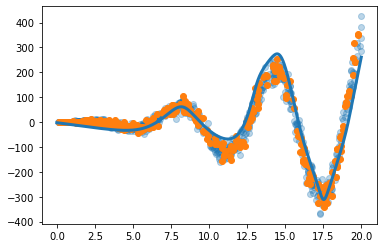

In [17]:
x_ = np.linspace(0,20, 1000).reshape(1000,1)

plt.plot(x_, model_diff(x_), lw=3)

plt.scatter(X_train, y_train, alpha=0.3)
plt.scatter(X_test,y_test, alpha=1)

### Trying derivatives

32/32 [==============================] - 0s 778us/step


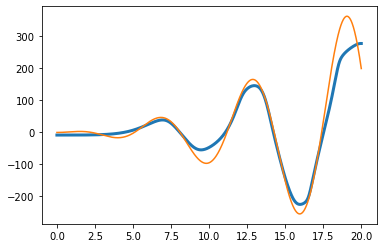

In [18]:
# large step for derivative
h = 1

plt.plot(x_, (model_diff(x_+h) - model_diff(x_-h))/(2*h), lw=3)
plt.plot(x_, 2*x_*np.sin(x_) + x_**2*np.cos(x_))
plt.show()

In [19]:
print("RMSE derivative:", round(np.sqrt(mean_squared_error(
    (model_diff(x_+h) - model_diff(x_-h))/(2*h), 
    2*x_*np.sin(x_) + x_**2*np.cos(x_))),2)
)

32/32 [==============================] - 0s 782us/step
RMSE derivative: 33.91


32/32 [==============================] - 0s 738us/step


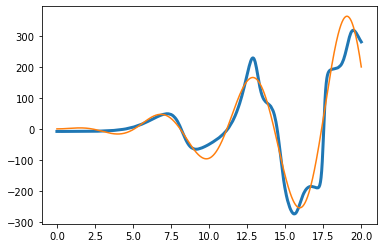

In [20]:
# smallr step for derivative
h = 0.001

plt.plot(x_, (model_diff(x_+h) - model_diff(x_-h))/(2*h), lw=3)
plt.plot(x_, 2*x_*np.sin(x_) + x_**2*np.cos(x_))
plt.show()

In [21]:
print("RMSE derivative:", round(np.sqrt(mean_squared_error(
    (model_diff(x_+h) - model_diff(x_-h))/(2*h), 
    2*x_*np.sin(x_) + x_**2*np.cos(x_))),2)
)

32/32 [==============================] - 0s 758us/step
RMSE derivative: 39.13


## Conclusions

It turns out that a well-chosen decision tree can actually build a better approximant for the derivative than the smooth model! It is all about properly choosing the step size.

Finding the optimal step size for a known derivative:

In [22]:
model = XGBRegressor(random_state=2, max_depth=3)
model.fit(X_train, y_train)

x_ = np.linspace(0,20, 1000).reshape(1000,1)

In [24]:
steps = np.arange(0.01, 2, 0.01)
rmse = [np.sqrt(mean_squared_error(
        (model.predict(x_+h) - model.predict(x_-h))/(2*h), 
        2*x_*np.sin(x_) + x_**2*np.cos(x_)))
        for h in steps]

In [34]:
best_step = steps[np.argmin(rmse)]
print("Best step size:", round(best_step,3))
print("Best RMSE:", round(np.min(rmse),3))

Best step size: 0.69
Best RMSE: 17.695


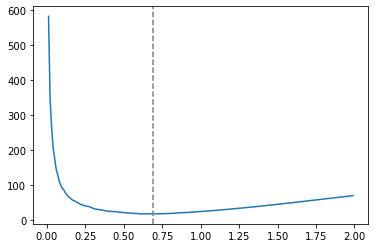

In [36]:
plt.plot(steps, rmse)
plt.axvline(best_step, linestyle='--', color='gray')
plt.show()

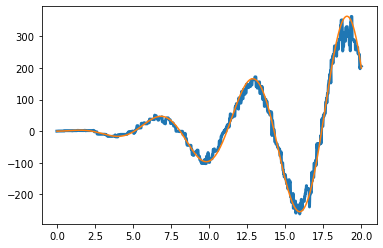

In [35]:
h = best_step

plt.plot(x_, (model.predict(x_+h) - model.predict(x_-h))/(2*h), lw=3)
plt.plot(x_, 2*x_*np.sin(x_) + x_**2*np.cos(x_))
plt.show()